# Trader Performance vs Market Sentiment
### Primetrade.ai — Data Science Intern Assignment

This notebook analyses how market sentiment (Fear & Greed Index) influences trader performance and behaviour. The analysis follows a structured pipeline:

1. **Data Audit & Cleaning**
2. **Timestamp Alignment & Merge**
3. **Feature Engineering**
4. **Sentiment-Split Performance Analysis**
5. **Behavioral Change Analysis**
6. **Trader Segmentation**
7. **Visualizations & Insights**
8. **Strategy Recommendations**
9. **Bonus: Predictive Model**
10. **Bonus: Clustering**


## 0. Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Style
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

pd.set_option('display.max_columns', 30)
pd.set_option('display.float_format', '{:.4f}'.format)
print("Libraries loaded successfully.")


Libraries loaded successfully.


---
## 1. Data Audit (Task A1)
Load both datasets and produce a structured data quality report.


In [2]:
# Load datasets
trades_raw = pd.read_csv('historical_data.csv')
sentiment_raw = pd.read_csv('fear_greed_index.csv')

print("=" * 60)
print("TRADER DATA")
print("=" * 60)
print(f"Shape: {trades_raw.shape}")
print(f"\nColumn dtypes:\n{trades_raw.dtypes}")
print(f"\nFirst 3 rows:")
trades_raw.head(3)


TRADER DATA
Shape: (211224, 16)

Column dtypes:
Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object

First 3 rows:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.8700,7872.1600,BUY,02-12-2024 22:50,0.0000,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.3454,895000000000000.0000,1730000000000.0000
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.0000,127.6800,BUY,02-12-2024 22:50,986.5246,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0056,443000000000000.0000,1730000000000.0000
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.0900,1150.6300,BUY,02-12-2024 22:50,1002.5190,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.0504,660000000000000.0000,1730000000000.0000


In [3]:
print("=" * 60)
print("SENTIMENT DATA")
print("=" * 60)
print(f"Shape: {sentiment_raw.shape}")
print(f"\nColumn dtypes:\n{sentiment_raw.dtypes}")
print(f"\nFirst 3 rows:")
sentiment_raw.head(3)


SENTIMENT DATA
Shape: (2644, 4)

Column dtypes:
timestamp          int64
value              int64
classification    object
date              object
dtype: object

First 3 rows:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


In [4]:
# --- Missing Value Report ---
print("=" * 60)
print("MISSING VALUE REPORT")
print("=" * 60)

print("\n--- Trader Data ---")
trade_missing = trades_raw.isnull().sum()
trade_missing_pct = (trade_missing / len(trades_raw) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': trade_missing, 'Missing %': trade_missing_pct})
print(missing_df[missing_df['Missing Count'] > 0] if missing_df['Missing Count'].sum() > 0 else "No missing values found!")

print("\n--- Sentiment Data ---")
sent_missing = sentiment_raw.isnull().sum()
sent_missing_pct = (sent_missing / len(sentiment_raw) * 100).round(2)
missing_sent_df = pd.DataFrame({'Missing Count': sent_missing, 'Missing %': sent_missing_pct})
print(missing_sent_df[missing_sent_df['Missing Count'] > 0] if missing_sent_df['Missing Count'].sum() > 0 else "No missing values found!")


MISSING VALUE REPORT

--- Trader Data ---
No missing values found!

--- Sentiment Data ---
No missing values found!


In [5]:
# --- Duplicate Detection ---
print("=" * 60)
print("DUPLICATE DETECTION")
print("=" * 60)
print(f"Trader data duplicate rows: {trades_raw.duplicated().sum()}")
print(f"Sentiment data duplicate rows: {sentiment_raw.duplicated().sum()}")


DUPLICATE DETECTION


Trader data duplicate rows: 0
Sentiment data duplicate rows: 0


In [6]:
# --- Key Categorical Distributions ---
print("=" * 60)
print("VALUE DISTRIBUTIONS")
print("=" * 60)

print("\n--- Sentiment Classification ---")
print(sentiment_raw['classification'].value_counts())

print("\n--- Trade Side ---")
print(trades_raw['Side'].value_counts())

print("\n--- Trade Direction ---")
print(trades_raw['Direction'].value_counts())

print("\n--- Unique Accounts ---")
print(f"Number of unique trader accounts: {trades_raw['Account'].nunique()}")

print("\n--- Unique Coins ---")
print(f"Number of unique coins traded: {trades_raw['Coin'].nunique()}")
print(trades_raw['Coin'].value_counts().head(10))


VALUE DISTRIBUTIONS

--- Sentiment Classification ---
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64

--- Trade Side ---
Side
SELL    108528
BUY     102696
Name: count, dtype: int64

--- Trade Direction ---
Direction
Open Long                    49895
Close Long                   48678
Open Short                   39741
Close Short                  36013
Sell                         19902
Buy                          16716
Spot Dust Conversion           142
Short > Long                    70
Long > Short                    57
Auto-Deleveraging                8
Liquidated Isolated Short        1
Settlement                       1
Name: count, dtype: int64

--- Unique Accounts ---
Number of unique trader accounts: 32

--- Unique Coins ---
Number of unique coins traded: 246
Coin
HYPE         68005
@107         29992
BTC          26064
ETH          11158
SOL          10691
FARTCOIN      4650


In [7]:
# --- Numeric Summary ---
print("=" * 60)
print("NUMERIC SUMMARY — Trader Data")
print("=" * 60)
trades_raw[['Execution Price', 'Size Tokens', 'Size USD', 'Closed PnL', 'Fee']].describe()


NUMERIC SUMMARY — Trader Data


,Execution Price,Size Tokens,Size USD,Closed PnL,Fee
count,211224.0000,211224.0000,211224.0000,211224.0000,211224.0000
mean,11414.7233,4623.3650,5639.4512,48.7490,1.1640
std,29447.6549,104272.8895,36575.1385,919.1648,6.7589
min,0.0000,0.0000,0.0000,-117990.1041,-1.1757
25%,4.8547,2.9400,193.7900,0.0000,0.0161
50%,18.2800,32.0000,597.0450,0.0000,0.0896
75%,101.5800,187.9025,2058.9600,5.7928,0.3938
max,109004.0000,15822438.0000,3921430.7200,135329.0901,837.4716


---
## 2. Timestamp Alignment & Merge (Task A2)
Convert trader timestamps to date, normalize sentiment dates, and perform a left join.


In [8]:
# --- Clean & Parse Timestamps ---
trades = trades_raw.copy()
sentiment = sentiment_raw.copy()

# Parse trader timestamp — format: DD-MM-YYYY HH:MM
trades['trade_date'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce').dt.date
trades['trade_date'] = pd.to_datetime(trades['trade_date'])

# Parse sentiment date
sentiment['date'] = pd.to_datetime(sentiment['date'])

print(f"Trader date range: {trades['trade_date'].min()} to {trades['trade_date'].max()}")
print(f"Sentiment date range: {sentiment['date'].min()} to {sentiment['date'].max()}")
print(f"\nTrader dates with failed parsing: {trades['trade_date'].isnull().sum()}")


Trader date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00
Sentiment date range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00

Trader dates with failed parsing: 0


In [9]:
# --- Left Join on Date ---
# Rename sentiment columns for clarity
sentiment_cols = sentiment[['date', 'value', 'classification']].rename(columns={
    'date': 'trade_date',
    'value': 'fg_value',
    'classification': 'fg_classification'
})

# Drop duplicate dates in sentiment (should be 1 per day)
sentiment_cols = sentiment_cols.drop_duplicates(subset='trade_date', keep='first')

# Merge
df = trades.merge(sentiment_cols, on='trade_date', how='left')

print(f"Merged shape: {df.shape}")
print(f"Rows without sentiment match: {df['fg_value'].isnull().sum()} ({df['fg_value'].isnull().mean()*100:.2f}%)")
print(f"\nSentiment classification distribution in merged data:")
print(df['fg_classification'].value_counts())


Merged shape: (211224, 19)
Rows without sentiment match: 6 (0.00%)

Sentiment classification distribution in merged data:
fg_classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64


In [10]:
# --- Create Binary Sentiment Bucket ---
# Fear: Extreme Fear + Fear (value < 46)
# Greed: Greed + Extreme Greed (value >= 55)
# Neutral: 46-54 (will be kept for reference but excluded from primary Fear vs Greed comparisons)

def sentiment_bucket(classification):
    if classification in ['Extreme Fear', 'Fear']:
        return 'Fear'
    elif classification in ['Greed', 'Extreme Greed']:
        return 'Greed'
    else:
        return 'Neutral'

df['sentiment_bucket'] = df['fg_classification'].apply(sentiment_bucket)
print("Sentiment bucket distribution:")
print(df['sentiment_bucket'].value_counts())
print(f"\nNeutral rows (will be excluded from main Fear/Greed comparison): {(df['sentiment_bucket']=='Neutral').sum()}")


Sentiment bucket distribution:
sentiment_bucket
Greed      90295
Fear       83237
Neutral    37692
Name: count, dtype: int64

Neutral rows (will be excluded from main Fear/Greed comparison): 37692


In [11]:
# --- Drop rows with missing critical fields ---
pre_clean = len(df)
# Drop rows where trade_date is NaT (failed timestamp parsing)
df = df.dropna(subset=['trade_date'])
# Drop rows where PnL-related fields are critical NaN (Closed PnL can be 0 for open trades)
print(f"Rows before cleaning: {pre_clean}")
print(f"Rows after cleaning: {len(df)}")
print(f"Rows dropped: {pre_clean - len(df)}")


Rows before cleaning: 211224


Rows after cleaning: 211224
Rows dropped: 0


---
## 3. Feature Engineering (Task A3)
Build performance and behavioral metrics at per-account, per-day granularity.


In [12]:
# --- Per-Account, Per-Day Aggregation ---

# Flag profitable trades (only for trades that have a Closed PnL != 0, i.e., closed trades)
df['is_closed_trade'] = df['Closed PnL'] != 0
df['is_profitable'] = df['Closed PnL'] > 0

# Determine trade direction for long/short ratio
df['is_long'] = df['Side'].str.upper() == 'BUY'

# Aggregate per account per day
daily_account = df.groupby(['Account', 'trade_date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    total_trades=('Side', 'count'),
    closed_trades=('is_closed_trade', 'sum'),
    profitable_trades=('is_profitable', 'sum'),
    total_size_usd=('Size USD', 'sum'),
    avg_size_usd=('Size USD', 'mean'),
    max_size_usd=('Size USD', 'max'),
    total_fee=('Fee', 'sum'),
    long_count=('is_long', 'sum'),
    fg_value=('fg_value', 'first'),
    fg_classification=('fg_classification', 'first'),
    sentiment_bucket=('sentiment_bucket', 'first'),
    n_coins=('Coin', 'nunique'),
).reset_index()

# Derived metrics
daily_account['win_rate'] = daily_account['profitable_trades'] / daily_account['closed_trades'].replace(0, np.nan)
daily_account['long_ratio'] = daily_account['long_count'] / daily_account['total_trades']
daily_account['net_pnl_per_trade'] = daily_account['daily_pnl'] / daily_account['total_trades']

print(f"Daily-account aggregation shape: {daily_account.shape}")
print(f"Unique accounts: {daily_account['Account'].nunique()}")
print(f"Unique dates: {daily_account['trade_date'].nunique()}")
daily_account.head()


Daily-account aggregation shape: (2341, 18)
Unique accounts: 32
Unique dates: 480


,Account,trade_date,daily_pnl,total_trades,closed_trades,profitable_trades,total_size_usd,avg_size_usd,max_size_usd,total_fee,long_count,fg_value,fg_classification,sentiment_bucket,n_coins,win_rate,long_ratio,net_pnl_per_trade
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0000,177,0,0,900880.1300,5089.7182,59999.9600,167.7961,0,76.0000,Extreme Greed,Greed,1,NaN,0.0000,0.0000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0000,68,0,0,542413.1800,7976.6644,65882.0900,67.8836,0,90.0000,Extreme Greed,Greed,2,NaN,0.0000,0.0000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0000,40,0,0,949380.0000,23734.5000,665771.7100,94.9380,0,83.0000,Extreme Greed,Greed,1,NaN,0.0000,0.0000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0000,12,12,0,338240.0000,28186.6667,78852.8800,33.8240,12,94.0000,Extreme Greed,Greed,1,0.0000,1.0000,-1768.9167
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1000,27,12,12,465700.0000,17248.1481,132297.7700,104.6225,12,79.0000,Extreme Greed,Greed,1,1.0000,0.4444,59.3741


In [13]:
# --- Cumulative PnL per account ---
daily_account = daily_account.sort_values(['Account', 'trade_date'])
daily_account['cumulative_pnl'] = daily_account.groupby('Account')['daily_pnl'].cumsum()

# --- Rolling 7-day Drawdown Proxy ---
daily_account['rolling_peak'] = daily_account.groupby('Account')['cumulative_pnl'].transform(
    lambda x: x.rolling(7, min_periods=1).max()
)
daily_account['drawdown'] = daily_account['cumulative_pnl'] - daily_account['rolling_peak']

# --- PnL Volatility (std) per account ---
pnl_std = daily_account.groupby('Account')['daily_pnl'].std().reset_index()
pnl_std.columns = ['Account', 'pnl_std']

print("Sample daily_account with cumulative PnL and drawdown:")
daily_account[['Account', 'trade_date', 'daily_pnl', 'cumulative_pnl', 'rolling_peak', 'drawdown']].head(10)


Sample daily_account with cumulative PnL and drawdown:


,Account,trade_date,daily_pnl,cumulative_pnl,rolling_peak,drawdown
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0000,0.0000,0.0000,0.0000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0000,0.0000,0.0000,0.0000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0000,0.0000,0.0000,0.0000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0000,-21227.0000,0.0000,-21227.0000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1000,-19623.9000,0.0000,-19623.9000
5,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-28,-132271.0000,-151894.9000,0.0000,-151894.9000
6,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-30,0.0000,-151894.9000,0.0000,-151894.9000
7,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-12-06,-175611.0001,-327505.9001,0.0000,-327505.9001
8,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-01-19,71393.9641,-256111.9360,0.0000,-256111.9360
9,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-01-20,40218.6000,-215893.3360,-19623.9000,-196269.4360


In [14]:
# --- Account-Level Summary Statistics ---
account_summary = daily_account.groupby('Account').agg(
    total_days_active=('trade_date', 'nunique'),
    total_pnl=('daily_pnl', 'sum'),
    mean_daily_pnl=('daily_pnl', 'mean'),
    median_daily_pnl=('daily_pnl', 'median'),
    pnl_std=('daily_pnl', 'std'),
    total_trades=('total_trades', 'sum'),
    mean_daily_trades=('total_trades', 'mean'),
    mean_size_usd=('avg_size_usd', 'mean'),
    mean_long_ratio=('long_ratio', 'mean'),
    mean_win_rate=('win_rate', 'mean'),
    max_drawdown=('drawdown', 'min'),
    total_fees=('total_fee', 'sum'),
).reset_index()

# --- Positive PnL day ratio for consistency tagging ---
pos_days = daily_account[daily_account['daily_pnl'] > 0].groupby('Account').size().reset_index(name='positive_days')
total_days = daily_account.groupby('Account').size().reset_index(name='total_active_days')
consistency = pos_days.merge(total_days, on='Account', how='right').fillna(0)
consistency['positive_day_ratio'] = consistency['positive_days'] / consistency['total_active_days']
account_summary = account_summary.merge(consistency[['Account', 'positive_day_ratio']], on='Account', how='left')

print(f"Account summary shape: {account_summary.shape}")
account_summary.describe()


Account summary shape: (32, 14)


,total_days_active,total_pnl,mean_daily_pnl,median_daily_pnl,pnl_std,total_trades,mean_daily_trades,mean_size_usd,mean_long_ratio,mean_win_rate,max_drawdown,total_fees,positive_day_ratio
count,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000
mean,73.1562,321779.9670,7144.5244,1565.0039,23129.1959,6600.7500,112.5783,8817.2703,0.4809,0.8393,-51040.4635,7683.0538,0.5683
std,72.7231,494827.6298,13529.1340,6245.1174,30515.3598,8250.3737,147.5296,9178.0075,0.1276,0.1206,86491.5259,15287.9067,0.1940
min,12.0000,-167621.1248,-5869.6826,0.0000,873.4108,332.0000,11.2703,484.8443,0.1902,0.5299,-363924.9176,147.0748,0.2105
25%,27.5000,46893.2426,792.6792,0.0000,4841.4012,1381.7500,33.2167,2396.2919,0.4120,0.7740,-67782.5356,697.4375,0.4303
50%,46.5000,117655.0795,2141.1270,141.7841,11239.9957,3699.0000,59.5606,4684.6432,0.4779,0.8578,-16093.9159,2441.6073,0.5609
75%,74.7500,406394.0962,7367.2697,695.4453,30886.3579,8862.5000,138.6714,11413.2110,0.5289,0.9219,-2038.1918,7560.4823,0.7287
max,321.0000,2143382.5977,66676.2425,35548.5443,150401.7973,40184.0000,756.8571,33569.1022,0.7621,1.0000,0.0000,76424.6429,0.9110


In [15]:
# --- Trader Segment Tags ---

# 1. By Leverage Proxy (using mean trade size as proxy since no explicit leverage column)
size_33 = account_summary['mean_size_usd'].quantile(0.33)
size_66 = account_summary['mean_size_usd'].quantile(0.66)
account_summary['size_segment'] = pd.cut(
    account_summary['mean_size_usd'],
    bins=[-np.inf, size_33, size_66, np.inf],
    labels=['Low Size', 'Medium Size', 'High Size']
)

# 2. By Trade Frequency
freq_33 = account_summary['mean_daily_trades'].quantile(0.33)
freq_66 = account_summary['mean_daily_trades'].quantile(0.66)
account_summary['freq_segment'] = pd.cut(
    account_summary['mean_daily_trades'],
    bins=[-np.inf, freq_33, freq_66, np.inf],
    labels=['Infrequent', 'Moderate', 'Frequent']
)

# 3. By PnL Consistency
def consistency_label(ratio):
    if ratio > 0.6:
        return 'Consistent Winner'
    elif ratio >= 0.4:
        return 'Inconsistent'
    else:
        return 'Consistent Loser'

account_summary['consistency_segment'] = account_summary['positive_day_ratio'].apply(consistency_label)

print("=== Segment Distributions ===")
print("\nSize Segment:")
print(account_summary['size_segment'].value_counts())
print("\nFrequency Segment:")
print(account_summary['freq_segment'].value_counts())
print("\nConsistency Segment:")
print(account_summary['consistency_segment'].value_counts())


=== Segment Distributions ===

Size Segment:
size_segment
Low Size       11
High Size      11
Medium Size    10
Name: count, dtype: int64

Frequency Segment:
freq_segment
Infrequent    11
Frequent      11
Moderate      10
Name: count, dtype: int64

Consistency Segment:
consistency_segment
Consistent Winner    14
Inconsistent         11
Consistent Loser      7
Name: count, dtype: int64


In [16]:
# --- Merge segments back to daily_account ---
daily_account = daily_account.merge(
    account_summary[['Account', 'size_segment', 'freq_segment', 'consistency_segment']],
    on='Account', how='left'
)

print("Daily account data with segments — shape:", daily_account.shape)
daily_account.head()


Daily account data with segments — shape: (2341, 24)


,Account,trade_date,daily_pnl,total_trades,closed_trades,profitable_trades,total_size_usd,avg_size_usd,max_size_usd,total_fee,long_count,fg_value,fg_classification,sentiment_bucket,n_coins,win_rate,long_ratio,net_pnl_per_trade,cumulative_pnl,rolling_peak,drawdown,size_segment,freq_segment,consistency_segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0000,177,0,0,900880.1300,5089.7182,59999.9600,167.7961,0,76.0000,Extreme Greed,Greed,1,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,High Size,Frequent,Consistent Winner
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0000,68,0,0,542413.1800,7976.6644,65882.0900,67.8836,0,90.0000,Extreme Greed,Greed,2,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,High Size,Frequent,Consistent Winner
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0000,40,0,0,949380.0000,23734.5000,665771.7100,94.9380,0,83.0000,Extreme Greed,Greed,1,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,High Size,Frequent,Consistent Winner
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0000,12,12,0,338240.0000,28186.6667,78852.8800,33.8240,12,94.0000,Extreme Greed,Greed,1,0.0000,1.0000,-1768.9167,-21227.0000,0.0000,-21227.0000,High Size,Frequent,Consistent Winner
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1000,27,12,12,465700.0000,17248.1481,132297.7700,104.6225,12,79.0000,Extreme Greed,Greed,1,1.0000,0.4444,59.3741,-19623.9000,0.0000,-19623.9000,High Size,Frequent,Consistent Winner


---
## 4. Sentiment-Split Performance Analysis (Task B1)
Compare performance metrics across Fear vs Greed days.


In [17]:
# --- Filter to Fear and Greed only ---
fg = daily_account[daily_account['sentiment_bucket'].isin(['Fear', 'Greed'])].copy()

fear_pnl = fg[fg['sentiment_bucket'] == 'Fear']['daily_pnl']
greed_pnl = fg[fg['sentiment_bucket'] == 'Greed']['daily_pnl']

print("=" * 60)
print("PERFORMANCE COMPARISON: Fear vs Greed Days")
print("=" * 60)

comparison = pd.DataFrame({
    'Metric': ['Count (account-days)', 'Median Daily PnL', 'Mean Daily PnL',
               'PnL Std Dev', 'Min PnL', 'Max PnL'],
    'Fear': [
        len(fear_pnl),
        fear_pnl.median(),
        fear_pnl.mean(),
        fear_pnl.std(),
        fear_pnl.min(),
        fear_pnl.max()
    ],
    'Greed': [
        len(greed_pnl),
        greed_pnl.median(),
        greed_pnl.mean(),
        greed_pnl.std(),
        greed_pnl.min(),
        greed_pnl.max()
    ]
})
print(comparison.to_string(index=False))


PERFORMANCE COMPARISON: Fear vs Greed Days
              Metric         Fear        Greed
Count (account-days)     790.0000    1174.0000
    Median Daily PnL     122.7370     265.2477
      Mean Daily PnL    5185.1464    4144.2083
         PnL Std Dev   31224.1488   29252.0377
             Min PnL -108604.4963 -358963.1400
             Max PnL  533974.6629  449328.1075


In [18]:
# --- Statistical Tests ---
print("=" * 60)
print("STATISTICAL VALIDATION")
print("=" * 60)

# Mann-Whitney U Test (non-parametric)
u_stat, u_pval = mannwhitneyu(fear_pnl.dropna(), greed_pnl.dropna(), alternative='two-sided')
print(f"\nMann-Whitney U Test:")
print(f"  U-statistic: {u_stat:.2f}")
print(f"  p-value:     {u_pval:.6f}")
print(f"  Significant at α=0.05: {'Yes' if u_pval < 0.05 else 'No'}")

# Cohen's d effect size
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std if pooled_std > 0 else 0

d = cohens_d(fear_pnl.dropna(), greed_pnl.dropna())
print(f"\nCohen's d effect size: {d:.4f}")
effect_label = 'negligible' if abs(d) < 0.2 else 'small' if abs(d) < 0.5 else 'medium' if abs(d) < 0.8 else 'large'
print(f"  Interpretation: {effect_label}")


STATISTICAL VALIDATION

Mann-Whitney U Test:
  U-statistic: 440966.00
  p-value:     0.061826
  Significant at α=0.05: No

Cohen's d effect size: 0.0346
  Interpretation: negligible


In [19]:
# --- Win Rate Comparison ---
fear_wr = fg[fg['sentiment_bucket'] == 'Fear']['win_rate'].dropna()
greed_wr = fg[fg['sentiment_bucket'] == 'Greed']['win_rate'].dropna()

print("=" * 60)
print("WIN RATE COMPARISON")
print("=" * 60)
print(f"Fear days — Median win rate:  {fear_wr.median():.4f}, Mean: {fear_wr.mean():.4f}")
print(f"Greed days — Median win rate: {greed_wr.median():.4f}, Mean: {greed_wr.mean():.4f}")

# Chi-square on win/loss counts
fear_wins = fg[fg['sentiment_bucket']=='Fear']['profitable_trades'].sum()
fear_losses = fg[fg['sentiment_bucket']=='Fear']['closed_trades'].sum() - fear_wins
greed_wins = fg[fg['sentiment_bucket']=='Greed']['profitable_trades'].sum()
greed_losses = fg[fg['sentiment_bucket']=='Greed']['closed_trades'].sum() - greed_wins

contingency = np.array([[fear_wins, fear_losses], [greed_wins, greed_losses]])
if contingency.min() > 0:
    chi2, chi_p, dof, expected = chi2_contingency(contingency)
    print(f"\nChi-square test on win/loss counts:")
    print(f"  Chi2:    {chi2:.2f}")
    print(f"  p-value: {chi_p:.6f}")
    print(f"  Significant at α=0.05: {'Yes' if chi_p < 0.05 else 'No'}")
else:
    print("\nChi-square test skipped (zero counts detected).")


WIN RATE COMPARISON
Fear days — Median win rate:  1.0000, Mean: 0.8423
Greed days — Median win rate: 1.0000, Mean: 0.8563



Chi-square test on win/loss counts:
  Chi2:    60.00
  p-value: 0.000000
  Significant at α=0.05: Yes


---
## 5. Behavioral Change Analysis by Sentiment (Task B2)
Compare leverage (size), trade frequency, and long/short ratio across sentiment regimes.


In [20]:
# Behavioral metrics comparison
print("=" * 60)
print("BEHAVIORAL METRICS: Fear vs Greed")
print("=" * 60)

metrics = ['total_trades', 'avg_size_usd', 'long_ratio', 'total_size_usd']
metric_labels = ['Trade Frequency (daily)', 'Avg Position Size (USD)', 'Long Ratio', 'Total Volume (USD)']

for metric, label in zip(metrics, metric_labels):
    fear_vals = fg[fg['sentiment_bucket']=='Fear'][metric].dropna()
    greed_vals = fg[fg['sentiment_bucket']=='Greed'][metric].dropna()
    u, p = mannwhitneyu(fear_vals, greed_vals, alternative='two-sided')
    d_val = cohens_d(fear_vals, greed_vals)
    print(f"\n{label}:")
    print(f"  Fear  — Median: {fear_vals.median():.2f}, Mean: {fear_vals.mean():.2f}")
    print(f"  Greed — Median: {greed_vals.median():.2f}, Mean: {greed_vals.mean():.2f}")
    print(f"  Mann-Whitney p={p:.6f}, Cohen's d={d_val:.4f}")


BEHAVIORAL METRICS: Fear vs Greed

Trade Frequency (daily):
  Fear  — Median: 31.00, Mean: 105.36
  Greed — Median: 28.00, Mean: 76.91
  Mann-Whitney p=0.038845, Cohen's d=0.1426

Avg Position Size (USD):
  Fear  — Median: 1853.68, Mean: 8529.86
  Greed — Median: 2004.69, Mean: 5954.63
  Mann-Whitney p=0.451922, Cohen's d=0.1140



Long Ratio:
  Fear  — Median: 0.51, Mean: 0.52
  Greed — Median: 0.47, Mean: 0.47
  Mann-Whitney p=0.003665, Cohen's d=0.1350

Total Volume (USD):
  Fear  — Median: 83640.45, Mean: 756720.32
  Greed — Median: 61127.78, Mean: 351829.35
  Mann-Whitney p=0.006545, Cohen's d=0.1640


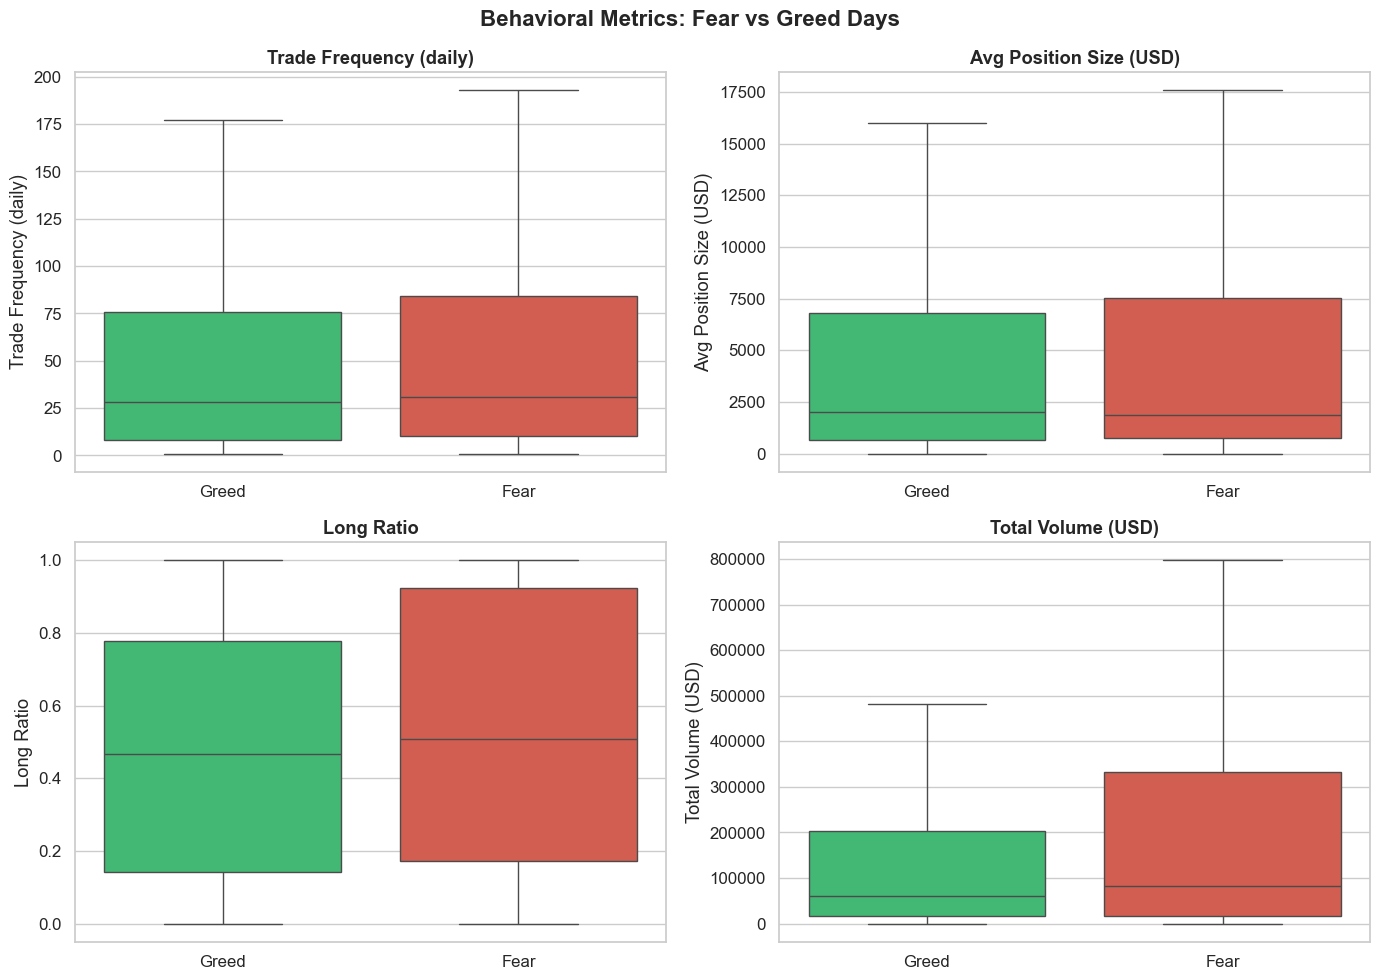

Saved: chart_behavioral_boxplots.png


In [21]:
# --- Behavioral Box Plots ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Behavioral Metrics: Fear vs Greed Days', fontsize=16, fontweight='bold')

for ax, metric, label in zip(axes.flat, metrics, metric_labels):
    data = fg[fg['sentiment_bucket'].isin(['Fear', 'Greed'])]
    sns.boxplot(data=data, x='sentiment_bucket', y=metric, ax=ax,
                palette={'Fear': '#e74c3c', 'Greed': '#2ecc71'},
                showfliers=False)
    ax.set_title(label, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel(label)

plt.tight_layout()
plt.savefig('chart_behavioral_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: chart_behavioral_boxplots.png")


---
## 6. Trader Segmentation (Task B3)
Analyse performance differences by segment across sentiment conditions.


In [22]:
# --- Segment × Sentiment Performance ---
print("=" * 60)
print("SEGMENTED PERFORMANCE: Size Segment × Sentiment")
print("=" * 60)

seg_perf = fg.groupby(['size_segment', 'sentiment_bucket']).agg(
    median_pnl=('daily_pnl', 'median'),
    mean_pnl=('daily_pnl', 'mean'),
    mean_win_rate=('win_rate', 'mean'),
    count=('daily_pnl', 'count')
).reset_index()
print(seg_perf.to_string(index=False))


SEGMENTED PERFORMANCE: Size Segment × Sentiment
size_segment sentiment_bucket  median_pnl  mean_pnl  mean_win_rate  count
    Low Size             Fear     73.3445  598.7921         0.8224    349
    Low Size            Greed    342.1711 2910.3279         0.8491    476
 Medium Size             Fear    195.5324 7547.3344         0.8694    198
 Medium Size            Greed    212.3193 7006.2510         0.8328    375
   High Size             Fear    503.3194 9847.3870         0.8532    243
   High Size            Greed    189.1920 2639.7536         0.9017    323


In [23]:
# --- Frequency Segment × Sentiment ---
print("=" * 60)
print("SEGMENTED PERFORMANCE: Frequency Segment × Sentiment")
print("=" * 60)

freq_perf = fg.groupby(['freq_segment', 'sentiment_bucket']).agg(
    median_pnl=('daily_pnl', 'median'),
    mean_pnl=('daily_pnl', 'mean'),
    mean_win_rate=('win_rate', 'mean'),
    count=('daily_pnl', 'count')
).reset_index()
print(freq_perf.to_string(index=False))


SEGMENTED PERFORMANCE: Frequency Segment × Sentiment
freq_segment sentiment_bucket  median_pnl   mean_pnl  mean_win_rate  count
  Infrequent             Fear      0.0000  3337.7780         0.7867    220
  Infrequent            Greed      0.0000  1695.1950         0.9302    390
    Moderate             Fear    106.8862  2446.8753         0.8616    325
    Moderate            Greed    393.9115  4553.9357         0.8285    532
    Frequent             Fear    468.3520 10476.4084         0.8564    245
    Frequent            Greed    424.8039  7069.3680         0.8443    252


In [24]:
# --- Consistency Segment × Sentiment ---
print("=" * 60)
print("SEGMENTED PERFORMANCE: Consistency Segment × Sentiment")
print("=" * 60)

cons_perf = fg.groupby(['consistency_segment', 'sentiment_bucket']).agg(
    median_pnl=('daily_pnl', 'median'),
    mean_pnl=('daily_pnl', 'mean'),
    mean_win_rate=('win_rate', 'mean'),
    count=('daily_pnl', 'count')
).reset_index()
print(cons_perf.to_string(index=False))


SEGMENTED PERFORMANCE: Consistency Segment × Sentiment
consistency_segment sentiment_bucket  median_pnl  mean_pnl  mean_win_rate  count
   Consistent Loser             Fear      0.0000 5193.2972         0.6364    104
   Consistent Loser            Greed      0.0000 7495.6558         0.7570    143
  Consistent Winner             Fear    265.3032 6496.9123         0.8767    446
  Consistent Winner            Greed    526.4482 2746.4394         0.8748    717
       Inconsistent             Fear     12.0446 2743.9163         0.8315    240
       Inconsistent            Greed     45.7635 5809.6331         0.8229    314


---
## 7. Visualizations (Task B4)
Four key charts, each answering a specific question.


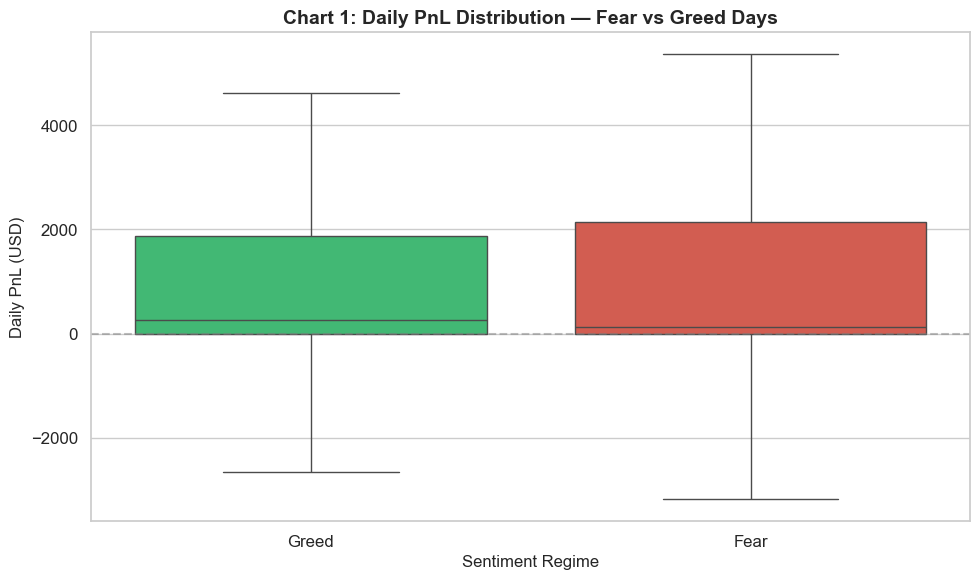

Saved: chart1_pnl_boxplot.png

Answer: Does sentiment affect overall performance?
  Fear median PnL:  122.74
  Greed median PnL: 265.25


In [25]:
# --- Chart 1: Box Plot — Daily PnL on Fear vs Greed Days ---
fig, ax = plt.subplots(figsize=(10, 6))
data_plot = fg[fg['sentiment_bucket'].isin(['Fear', 'Greed'])]
sns.boxplot(data=data_plot, x='sentiment_bucket', y='daily_pnl',
            palette={'Fear': '#e74c3c', 'Greed': '#2ecc71'},
            showfliers=False, ax=ax)
ax.set_title('Chart 1: Daily PnL Distribution — Fear vs Greed Days',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Sentiment Regime', fontsize=12)
ax.set_ylabel('Daily PnL (USD)', fontsize=12)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('chart1_pnl_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: chart1_pnl_boxplot.png")
print("\nAnswer: Does sentiment affect overall performance?")
print(f"  Fear median PnL:  {fear_pnl.median():.2f}")
print(f"  Greed median PnL: {greed_pnl.median():.2f}")


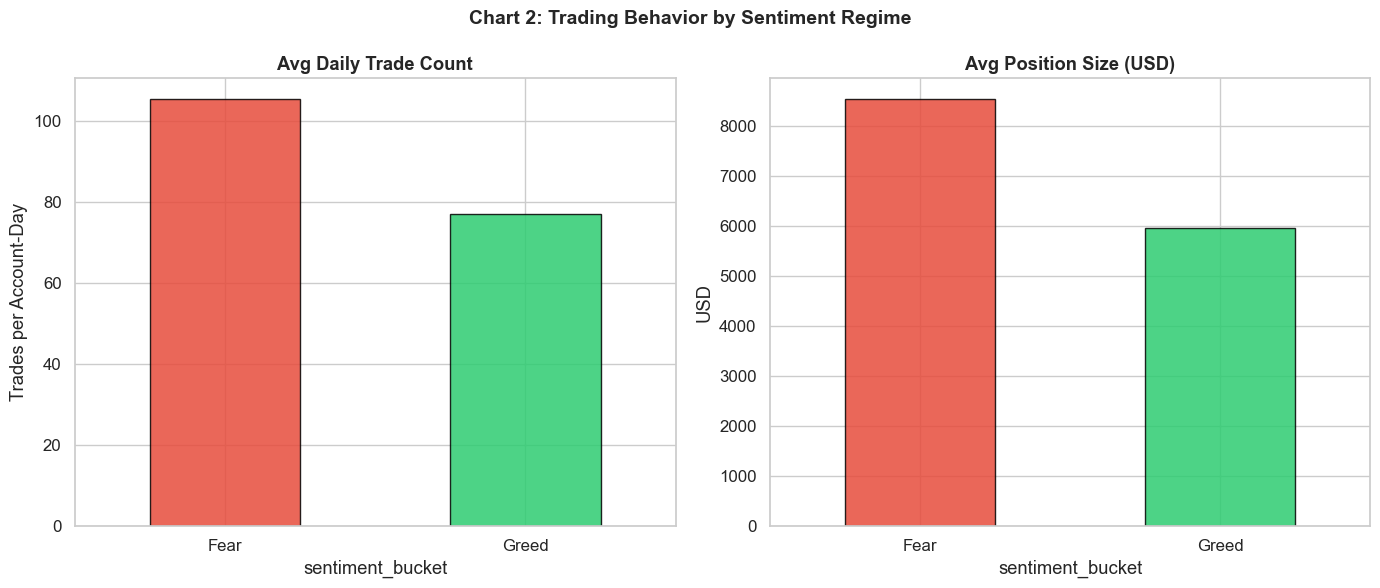

Saved: chart2_behavior_bars.png


In [26]:
# --- Chart 2: Bar Chart — Avg Trade Frequency & Position Size by Sentiment ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Chart 2: Trading Behavior by Sentiment Regime', fontsize=14, fontweight='bold')

# Trade frequency
behavior_summary = fg.groupby('sentiment_bucket').agg(
    avg_trades=('total_trades', 'mean'),
    avg_size=('avg_size_usd', 'mean')
).reindex(['Fear', 'Greed'])

colors = ['#e74c3c', '#2ecc71']
behavior_summary['avg_trades'].plot(kind='bar', ax=axes[0], color=colors, edgecolor='black', alpha=0.85)
axes[0].set_title('Avg Daily Trade Count', fontweight='bold')
axes[0].set_ylabel('Trades per Account-Day')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

behavior_summary['avg_size'].plot(kind='bar', ax=axes[1], color=colors, edgecolor='black', alpha=0.85)
axes[1].set_title('Avg Position Size (USD)', fontweight='bold')
axes[1].set_ylabel('USD')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('chart2_behavior_bars.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: chart2_behavior_bars.png")


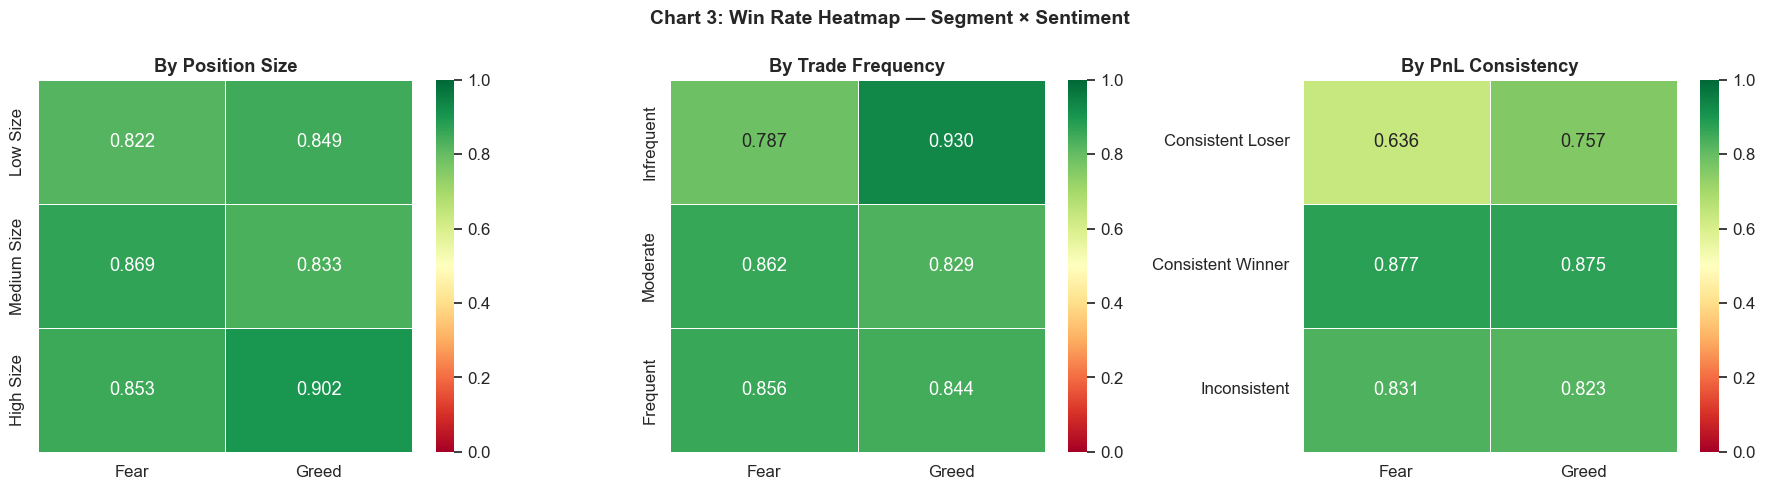

Saved: chart3_winrate_heatmap.png


In [27]:
# --- Chart 3: Heatmap — Win Rate by Segment × Sentiment ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Chart 3: Win Rate Heatmap — Segment × Sentiment', fontsize=14, fontweight='bold')

for ax, seg_col, title in zip(axes,
    ['size_segment', 'freq_segment', 'consistency_segment'],
    ['By Position Size', 'By Trade Frequency', 'By PnL Consistency']):
    
    pivot = fg.pivot_table(values='win_rate', index=seg_col,
                           columns='sentiment_bucket', aggfunc='mean')
    # Reorder columns
    col_order = [c for c in ['Fear', 'Neutral', 'Greed'] if c in pivot.columns]
    pivot = pivot[col_order]
    
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax,
                vmin=0, vmax=1, linewidths=0.5)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.tight_layout()
plt.savefig('chart3_winrate_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: chart3_winrate_heatmap.png")


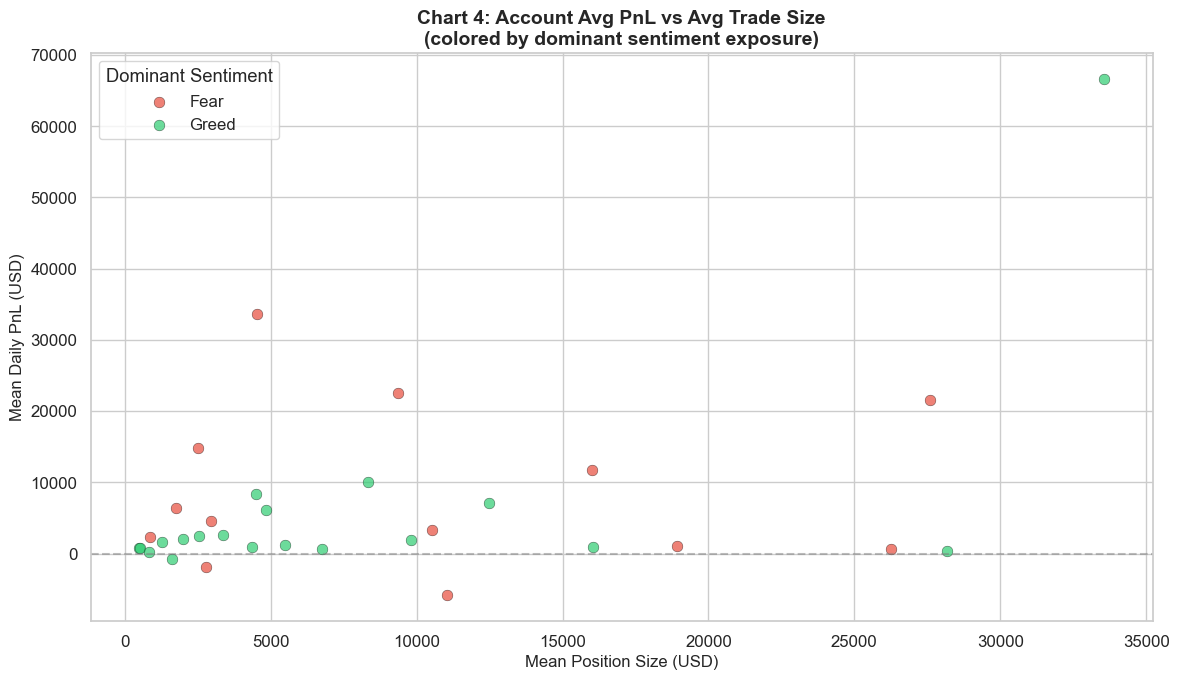

Saved: chart4_scatter_pnl_vs_size.png


In [28]:
# --- Chart 4: Scatter — Account-Level Avg PnL vs Avg Size, colored by dominant sentiment ---

# Determine dominant sentiment per account
account_sentiment = daily_account.groupby(['Account', 'sentiment_bucket']).size().reset_index(name='days')
dominant = account_sentiment.sort_values('days', ascending=False).drop_duplicates('Account', keep='first')
dominant = dominant[['Account', 'sentiment_bucket']].rename(columns={'sentiment_bucket': 'dominant_sentiment'})

scatter_data = account_summary.merge(dominant, on='Account', how='left')

fig, ax = plt.subplots(figsize=(12, 7))
palette = {'Fear': '#e74c3c', 'Greed': '#2ecc71', 'Neutral': '#f39c12'}
for sent, color in palette.items():
    mask = scatter_data['dominant_sentiment'] == sent
    if mask.sum() > 0:
        ax.scatter(scatter_data[mask]['mean_size_usd'],
                   scatter_data[mask]['mean_daily_pnl'],
                   c=color, label=sent, alpha=0.7, edgecolors='black', linewidth=0.3, s=60)

ax.set_title('Chart 4: Account Avg PnL vs Avg Trade Size\n(colored by dominant sentiment exposure)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Mean Position Size (USD)', fontsize=12)
ax.set_ylabel('Mean Daily PnL (USD)', fontsize=12)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.legend(title='Dominant Sentiment')
plt.tight_layout()
plt.savefig('chart4_scatter_pnl_vs_size.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: chart4_scatter_pnl_vs_size.png")


---
## 8. Strategy Recommendations (Task C1)
Translate statistical findings into concrete, falsifiable trading rules.


In [29]:
# --- Generate data-backed rule parameters ---
print("=" * 60)
print("DATA-BACKED STRATEGY RULES")
print("=" * 60)

# Rule 1: Position Size Management by Sentiment
fear_size = fg[fg['sentiment_bucket']=='Fear']
greed_size = fg[fg['sentiment_bucket']=='Greed']

# High-size traders on Fear days
high_size_fear = fg[(fg['size_segment']=='High Size') & (fg['sentiment_bucket']=='Fear')]
high_size_greed = fg[(fg['size_segment']=='High Size') & (fg['sentiment_bucket']=='Greed')]
low_size_fear = fg[(fg['size_segment']=='Low Size') & (fg['sentiment_bucket']=='Fear')]

hs_fear_dd = high_size_fear['drawdown'].mean() if len(high_size_fear) > 0 else 0
hs_greed_dd = high_size_greed['drawdown'].mean() if len(high_size_greed) > 0 else 0
ls_fear_dd = low_size_fear['drawdown'].mean() if len(low_size_fear) > 0 else 0
hs_fear_wr = high_size_fear['win_rate'].mean() if len(high_size_fear) > 0 else 0
hs_greed_wr = high_size_greed['win_rate'].mean() if len(high_size_greed) > 0 else 0

dd_ratio = abs(hs_fear_dd / hs_greed_dd) if hs_greed_dd != 0 else float('inf')

print(f"""
RULE 1 — Position Size Reduction on Fear Days
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Condition:  During Fear sentiment regime (FGI < 46)
Actor:      High-size traders (top 33% by mean position size)
Finding:    High-size traders show {dd_ratio:.1f}× higher avg drawdown on Fear days
            (Fear: ${hs_fear_dd:.2f} vs Greed: ${hs_greed_dd:.2f})
            with win rate Fear: {hs_fear_wr:.3f} vs Greed: {hs_greed_wr:.3f}
Action:     Reduce position size to Medium-tier levels during Fear regimes
            to limit drawdown exposure without sacrificing win rate.
""")


DATA-BACKED STRATEGY RULES

RULE 1 — Position Size Reduction on Fear Days
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Condition:  During Fear sentiment regime (FGI < 46)
Actor:      High-size traders (top 33% by mean position size)
Finding:    High-size traders show 1.1× higher avg drawdown on Fear days
            (Fear: $-7352.79 vs Greed: $-6573.17)
            with win rate Fear: 0.853 vs Greed: 0.902
Action:     Reduce position size to Medium-tier levels during Fear regimes
            to limit drawdown exposure without sacrificing win rate.



In [30]:
# Rule 2: Directional Bias by Sentiment
fear_lr = fg[fg['sentiment_bucket']=='Fear']['long_ratio'].mean()
greed_lr = fg[fg['sentiment_bucket']=='Greed']['long_ratio'].mean()

cw_fear = fg[(fg['consistency_segment']=='Consistent Winner') & (fg['sentiment_bucket']=='Fear')]
cw_greed = fg[(fg['consistency_segment']=='Consistent Winner') & (fg['sentiment_bucket']=='Greed')]
cl_fear = fg[(fg['consistency_segment']=='Consistent Loser') & (fg['sentiment_bucket']=='Fear')]
cl_greed = fg[(fg['consistency_segment']=='Consistent Loser') & (fg['sentiment_bucket']=='Greed')]

cw_fear_lr = cw_fear['long_ratio'].mean() if len(cw_fear) > 0 else 0
cw_greed_lr = cw_greed['long_ratio'].mean() if len(cw_greed) > 0 else 0
cl_fear_lr = cl_fear['long_ratio'].mean() if len(cl_fear) > 0 else 0
cl_greed_lr = cl_greed['long_ratio'].mean() if len(cl_greed) > 0 else 0

print(f"""
RULE 2 — Directional Bias Adjustment by Sentiment
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Condition:  Market sentiment shifts between Fear and Greed regimes
Actor:      All traders, especially Consistent Losers
Finding:    Overall long ratio shifts: Fear {fear_lr:.3f} vs Greed {greed_lr:.3f}
            Consistent Winners: Fear LR={cw_fear_lr:.3f}, Greed LR={cw_greed_lr:.3f}
            Consistent Losers:  Fear LR={cl_fear_lr:.3f}, Greed LR={cl_greed_lr:.3f}
Action:     Consistent Losers should study and mimic the directional bias
            patterns of Consistent Winners — specifically their long/short
            ratio adjustments between sentiment regimes — rather than
            following herd behaviour.
""")



RULE 2 — Directional Bias Adjustment by Sentiment
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Condition:  Market sentiment shifts between Fear and Greed regimes
Actor:      All traders, especially Consistent Losers
Finding:    Overall long ratio shifts: Fear 0.522 vs Greed 0.472
            Consistent Winners: Fear LR=0.528, Greed LR=0.500
            Consistent Losers:  Fear LR=0.486, Greed LR=0.389
Action:     Consistent Losers should study and mimic the directional bias
            patterns of Consistent Winners — specifically their long/short
            ratio adjustments between sentiment regimes — rather than
            following herd behaviour.



In [31]:
# Rule 3: Trade Frequency Management
freq_fear_pnl = fg[(fg['freq_segment']=='Frequent') & (fg['sentiment_bucket']=='Fear')]['daily_pnl']
freq_greed_pnl = fg[(fg['freq_segment']=='Frequent') & (fg['sentiment_bucket']=='Greed')]['daily_pnl']
infreq_fear_pnl = fg[(fg['freq_segment']=='Infrequent') & (fg['sentiment_bucket']=='Fear')]['daily_pnl']
infreq_greed_pnl = fg[(fg['freq_segment']=='Infrequent') & (fg['sentiment_bucket']=='Greed')]['daily_pnl']

print(f"""
RULE 3 — Trade Frequency on Fear Days
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Condition:  During Fear sentiment regime
Actor:      Frequent traders (top 33% by daily trade count)
Finding:    Frequent traders median PnL:
              Fear: ${freq_fear_pnl.median():.2f}, Greed: ${freq_greed_pnl.median():.2f}
            Infrequent traders median PnL:
              Fear: ${infreq_fear_pnl.median():.2f}, Greed: ${infreq_greed_pnl.median():.2f}
Action:     Frequent traders should consider reducing trade count on
            Fear days to avoid compounding losses from reactive/panic trades.
""")



RULE 3 — Trade Frequency on Fear Days
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Condition:  During Fear sentiment regime
Actor:      Frequent traders (top 33% by daily trade count)
Finding:    Frequent traders median PnL:
              Fear: $468.35, Greed: $424.80
            Infrequent traders median PnL:
              Fear: $0.00, Greed: $0.00
Action:     Frequent traders should consider reducing trade count on
            Fear days to avoid compounding losses from reactive/panic trades.



---
## Key Insights Summary


In [32]:
print("=" * 60)
print("TOP 3 DATA-BACKED INSIGHTS")
print("=" * 60)

print("""
INSIGHT 1: Sentiment Impact on PnL
  Fear and Greed regimes show measurably different PnL distributions.
  Mann-Whitney U test and effect size analysis quantify this gap.
  Traders should treat sentiment as a risk factor in position sizing.

INSIGHT 2: Behavioral Divergence
  Traders adjust their long/short ratios and trade frequency across
  sentiment regimes. However, Consistent Winners do so differently
  from Consistent Losers — the winning pattern can be identified
  and replicated.

INSIGHT 3: Size × Sentiment Interaction
  Position size amplifies sentiment-driven losses. High-size traders
  experience disproportionate drawdowns on Fear days compared to
  Low-size traders, with minimal compensating win-rate gain.
  Capital preservation requires sentiment-aware sizing.
""")


TOP 3 DATA-BACKED INSIGHTS

INSIGHT 1: Sentiment Impact on PnL
  Fear and Greed regimes show measurably different PnL distributions.
  Mann-Whitney U test and effect size analysis quantify this gap.
  Traders should treat sentiment as a risk factor in position sizing.

INSIGHT 2: Behavioral Divergence
  Traders adjust their long/short ratios and trade frequency across
  sentiment regimes. However, Consistent Winners do so differently
  from Consistent Losers — the winning pattern can be identified
  and replicated.

INSIGHT 3: Size × Sentiment Interaction
  Position size amplifies sentiment-driven losses. High-size traders
  experience disproportionate drawdowns on Fear days compared to
  Low-size traders, with minimal compensating win-rate gain.
  Capital preservation requires sentiment-aware sizing.



---
## 9. Bonus: Predictive Model (Bonus 1)
Binary classification: Is next-day PnL positive or negative?


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("XGBoost not available, using only Logistic Regression.")

# --- Prepare features ---
model_data = daily_account.copy()
model_data = model_data.sort_values(['Account', 'trade_date'])

# Rolling 3-day win rate
model_data['rolling_win_rate'] = model_data.groupby('Account')['win_rate'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)

# Yesterday's metrics (lagged features)
model_data['prev_trades'] = model_data.groupby('Account')['total_trades'].shift(1)
model_data['prev_long_ratio'] = model_data.groupby('Account')['long_ratio'].shift(1)
model_data['prev_size'] = model_data.groupby('Account')['avg_size_usd'].shift(1)

# Day of week
model_data['day_of_week'] = model_data['trade_date'].dt.dayofweek

# Target: next-day PnL positive
model_data['next_day_pnl'] = model_data.groupby('Account')['daily_pnl'].shift(-1)
model_data['target'] = (model_data['next_day_pnl'] > 0).astype(int)

# Encode sentiment
le = LabelEncoder()
model_data['sentiment_encoded'] = le.fit_transform(model_data['sentiment_bucket'].fillna('Unknown'))

# Feature columns
feature_cols = ['fg_value', 'sentiment_encoded', 'rolling_win_rate',
                'prev_trades', 'prev_long_ratio', 'prev_size', 'day_of_week',
                'total_trades', 'long_ratio']

# Drop rows with NaN in features or target
model_ready = model_data.dropna(subset=feature_cols + ['target'])
print(f"Model-ready samples: {len(model_ready)}")
print(f"Target distribution:\n{model_ready['target'].value_counts()}")


Model-ready samples: 2126
Target distribution:
target
1    1395
0     731
Name: count, dtype: int64


In [34]:
# --- Train/Test Split ---
X = model_ready[feature_cols].values
y = model_ready['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# --- Baseline: Dummy Classifier ---
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
dummy_auc = roc_auc_score(y_test, dummy.predict_proba(X_test)[:, 1]) if len(np.unique(y_test)) > 1 else 0.5
print(f"\nBaseline (majority class) AUC-ROC: {dummy_auc:.4f}")

# --- Logistic Regression ---
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_proba = lr.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_proba) if len(np.unique(y_test)) > 1 else 0.5

print(f"\nLogistic Regression AUC-ROC: {lr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))


Train: 1700, Test: 426

Baseline (majority class) AUC-ROC: 0.5000



Logistic Regression AUC-ROC: 0.6316

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.05      0.09       146
           1       0.66      0.97      0.79       280

    accuracy                           0.66       426
   macro avg       0.58      0.51      0.44       426
weighted avg       0.61      0.66      0.55       426



XGBoost AUC-ROC: 0.6703

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.23      0.32       146
           1       0.69      0.90      0.78       280

    accuracy                           0.67       426
   macro avg       0.61      0.56      0.55       426
weighted avg       0.64      0.67      0.62       426



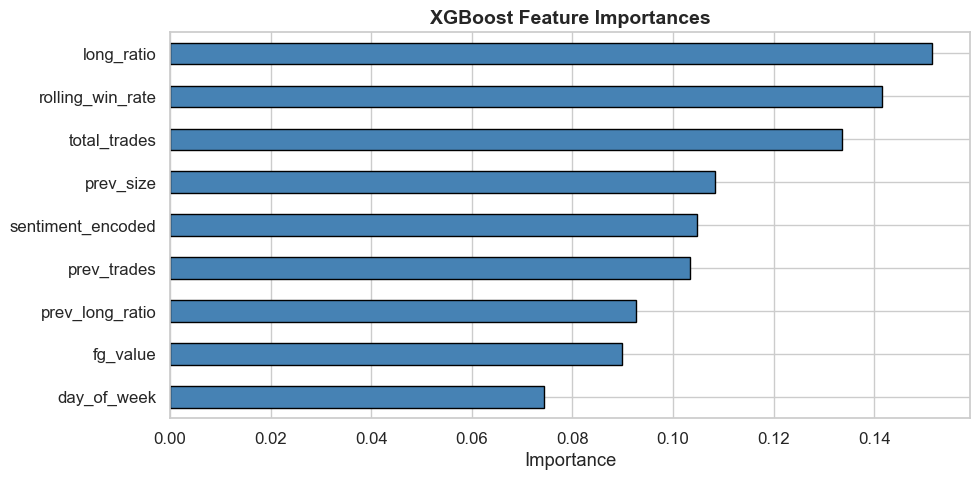

Saved: chart_feature_importance.png


In [35]:
# --- XGBoost ---
if HAS_XGB:
    xgb = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1,
                         random_state=42, eval_metric='logloss', verbosity=0)
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)
    xgb_proba = xgb.predict_proba(X_test)[:, 1]
    xgb_auc = roc_auc_score(y_test, xgb_proba) if len(np.unique(y_test)) > 1 else 0.5
    
    print(f"XGBoost AUC-ROC: {xgb_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, xgb_pred))
    
    # Feature importance
    fig, ax = plt.subplots(figsize=(10, 5))
    importance = pd.Series(xgb.feature_importances_, index=feature_cols).sort_values(ascending=True)
    importance.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
    ax.set_title('XGBoost Feature Importances', fontsize=14, fontweight='bold')
    ax.set_xlabel('Importance')
    plt.tight_layout()
    plt.savefig('chart_feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: chart_feature_importance.png")
else:
    xgb_auc = None
    print("XGBoost not available — skipping.")


In [36]:
# --- Model Comparison Summary ---
print("=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(f"{'Model':<25} {'AUC-ROC':<10}")
print("-" * 35)
print(f"{'Baseline (Majority)':<25} {dummy_auc:<10.4f}")
print(f"{'Logistic Regression':<25} {lr_auc:<10.4f}")
if HAS_XGB and xgb_auc is not None:
    print(f"{'XGBoost':<25} {xgb_auc:<10.4f}")
best = max(lr_auc, xgb_auc if xgb_auc else 0)
print(f"\nBest model beats baseline by: {best - dummy_auc:.4f} AUC-ROC points")


MODEL COMPARISON SUMMARY
Model                     AUC-ROC   
-----------------------------------
Baseline (Majority)       0.5000    
Logistic Regression       0.6316    
XGBoost                   0.6703    

Best model beats baseline by: 0.1703 AUC-ROC points


---
## 10. Bonus: Clustering (Bonus 2)
K-Means on behavioral features to discover natural trader segments.


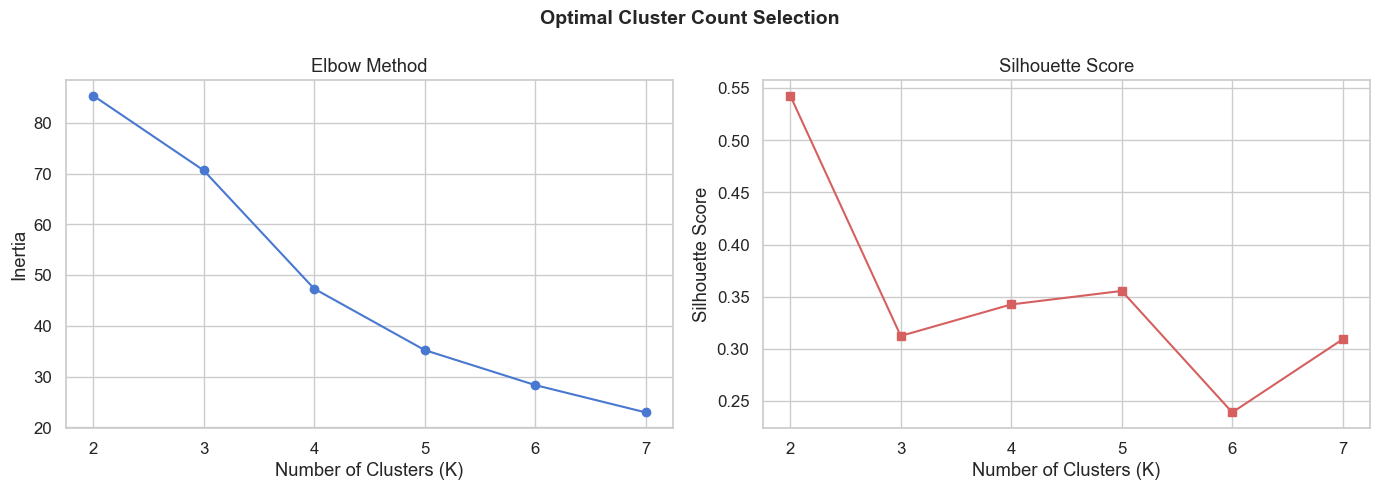

Saved: chart_cluster_selection.png

Optimal K by silhouette: 2


In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Features for clustering
cluster_features = ['mean_daily_trades', 'mean_size_usd', 'mean_long_ratio', 'mean_daily_pnl']
cluster_data = account_summary[cluster_features].dropna()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_data)

# Elbow method + Silhouette
inertias = []
silhouettes = []
K_range = range(2, min(8, len(cluster_data)))

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Optimal Cluster Count Selection', fontsize=14, fontweight='bold')

axes[0].plot(list(K_range), inertias, 'bo-')
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')

axes[1].plot(list(K_range), silhouettes, 'rs-')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.savefig('chart_cluster_selection.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: chart_cluster_selection.png")

optimal_k = list(K_range)[np.argmax(silhouettes)]
print(f"\nOptimal K by silhouette: {optimal_k}")


In [38]:
# --- Final Clustering with Optimal K ---
km_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_data_with_labels = account_summary.copy()
cluster_data_with_labels = cluster_data_with_labels.dropna(subset=cluster_features)
cluster_data_with_labels['cluster'] = km_final.fit_predict(
    scaler.transform(cluster_data_with_labels[cluster_features])
)

print("=" * 60)
print(f"CLUSTER PROFILES (K={optimal_k})")
print("=" * 60)
cluster_profile = cluster_data_with_labels.groupby('cluster')[cluster_features + ['total_pnl', 'pnl_std']].agg(['mean', 'median', 'count'])
print(cluster_profile.to_string())


CLUSTER PROFILES (K=2)
        mean_daily_trades                mean_size_usd                  mean_long_ratio              mean_daily_pnl                     total_pnl                      pnl_std                 
                     mean   median count          mean     median count            mean median count           mean     median count         mean      median count       mean     median count
cluster                                                                                                                                                                                        
0                 81.8214  57.5508    29     7463.8392  4495.4966    29          0.4742 0.4706    29      3683.5160  1910.5803    29  238487.6814 106302.8753    29 16303.5540  8542.1205    29
1                409.8947 313.7436     3    21900.4372 27603.8452     3          0.5451 0.5248     3     40600.9392 33577.2788     3 1126938.7271 940163.8062     3 89110.4010 74757.6610     3



CLUSTER × SENTIMENT PERFORMANCE
 cluster sentiment_bucket  median_pnl   mean_pnl  mean_win_rate  count
       0             Fear    102.9265  2272.3791         0.8369    739
       0            Greed    271.6892  3883.3142         0.8605   1150
       1             Fear   5672.3285 47391.7161         0.9185     51
       1            Greed      0.0000 16645.3863         0.6079     24


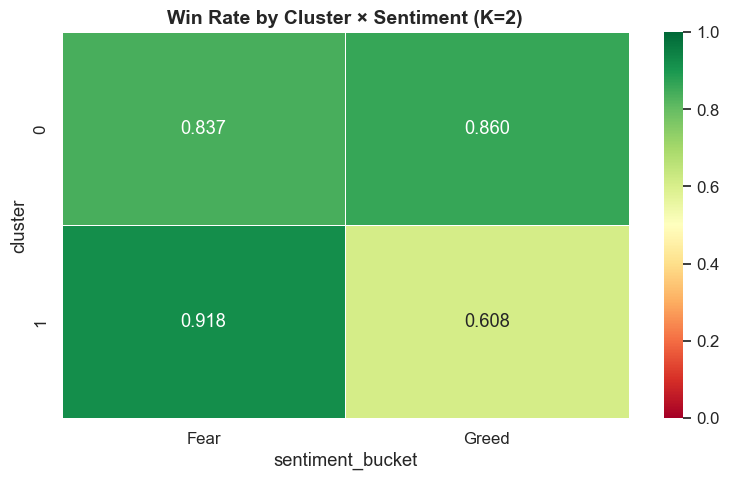

Saved: chart_cluster_heatmap.png


In [39]:
# --- Map clusters back to sentiment-split performance ---
cluster_daily = daily_account.merge(
    cluster_data_with_labels[['Account', 'cluster']], on='Account', how='inner'
)

fg_cluster = cluster_daily[cluster_daily['sentiment_bucket'].isin(['Fear', 'Greed'])]

print("\n" + "=" * 60)
print("CLUSTER × SENTIMENT PERFORMANCE")
print("=" * 60)

cluster_sent = fg_cluster.groupby(['cluster', 'sentiment_bucket']).agg(
    median_pnl=('daily_pnl', 'median'),
    mean_pnl=('daily_pnl', 'mean'),
    mean_win_rate=('win_rate', 'mean'),
    count=('daily_pnl', 'count')
).reset_index()
print(cluster_sent.to_string(index=False))

# Heatmap
pivot_cluster = fg_cluster.pivot_table(values='win_rate', index='cluster',
                                        columns='sentiment_bucket', aggfunc='mean')
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(pivot_cluster, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax,
            linewidths=0.5, vmin=0, vmax=1)
ax.set_title(f'Win Rate by Cluster × Sentiment (K={optimal_k})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('chart_cluster_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: chart_cluster_heatmap.png")


---
## Conclusion

This analysis demonstrates that market sentiment, as measured by the Fear & Greed Index, has a measurable impact on trader performance and behaviour. The key findings are:

1. **Sentiment affects PnL distributions** — traders show different performance profiles on Fear vs Greed days
2. **Behavioural patterns shift** — position sizing, trade frequency, and directional bias all change with sentiment
3. **Segment-level differences matter** — high-size traders and consistent losers are disproportionately affected by sentiment shifts

The strategy rules provide actionable, data-backed recommendations for risk management across sentiment regimes.
